In this notebook, I isolate the data preprocessing process in my implementation of Unrolled Optimization with Deep Priors 

Note that this code was adapted based on work from this [source](https://github.com/Zhengqi-Wu/Unrolled-optimization-with-deep-priors/blob/master/README.md) as well as chatGPT

Outline of notebook: 

Run these steps on the BSDS500 dataset 

* start with the 400 image data set
* scale the input images to 0,255
* crop them to 180x180
* randomly flip or rotate images by 90 degrees, to increase the size of the dataset 
* save that dataset as the y, original 
* add noise to all the images, with noise variation =25


We will ensure we get the results we expect by:

* counting the number of output images 
* ensuring the images are cropped, scaled 
* compare an original image with its noisy counterpart 

# Imports

In [1]:
# Import libraries
import numpy as np
import os
import cv2
import PIL
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [7]:
# Import dataset 
# Define the paths to the BSD500 dataset
data_dir = './BSDS500/data/images'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')

# Transforming the images

In [3]:
def addNoise(img, var):
    """Add noise to an image

    Args:
        img : an array representing an image
        var  sigma, noise variance

    Returns:
        _type_: iamge with added noise
    """
    noise = np.random.normal(scale=var, size=img.shape).astype(np.int16)
    img_noisy = np.clip(img.astype(np.int16) + noise, 0, 255).astype(np.uint8)
    return img_noisy

Here we do a trial run of the cleaning code, to ensure that everything works as expected. 

In [15]:
# Define the desired image size and noise variation
img_size = (180, 180)
noise_var = 25

# choose whether to convert to greyscake
convertToGrey = True

original_images = []
noisy_images = []

input_dir = train_dir

# Iterate over all images in the input directory
for img_name in os.listdir(input_dir):
    # Load the input image
    img_path = os.path.join(input_dir, img_name)  
    if img_path[-3:] != "jpg":
            continue
    img = cv2.imread(img_path)

    # Convert to grayscale 
    if convertToGrey == True:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Scale the image to 0-255 range and crop to desired size
    img = (img - img.min()) / (img.max() - img.min()) * 255
    img = img.astype(np.uint8)
    img = cv2.resize(img, img_size)
    

    # Randomly flip or rotate the image
    rand_num = np.random.randint(0, 6)
    if rand_num == 0:
        img1 = cv2.flip(img, 0)
        imgnoisy1 = addNoise(img1, var=noise_var)
        imgnoisy = addNoise(img, var=noise_var)
        original_images.append(img)
        original_images.append(img1)
        noisy_images.append(imgnoisy)
        noisy_images.append(imgnoisy1)
    elif rand_num == 1:
        img1 = cv2.flip(img, 1)
        imgnoisy1 = addNoise(img1, var=noise_var)
        imgnoisy = addNoise(img, var=noise_var)
        original_images.append(img)
        original_images.append(img1)
        noisy_images.append(imgnoisy)
        noisy_images.append(imgnoisy1)
    elif rand_num == 2:
        img1 = np.rot90(img)
        imgnoisy1 = addNoise(img1, var=noise_var)
        imgnoisy = addNoise(img, var=noise_var)
        original_images.append(img)
        original_images.append(img1)
        noisy_images.append(imgnoisy)
        noisy_images.append(imgnoisy1)
    else: 
    # Add noise to the image
        original_images.append(img)
        imgnoisy1 = addNoise(img, var=noise_var)
        noisy_images.append(imgnoisy1)

original_images = np.array(original_images, dtype=np.float32)
noisy_images = np.array(noisy_images, dtype=np.float32)


Now we will do some checks to ensure the data is how we believe it to be. 

In [11]:
print(f'size of datasets \n original {np.shape(original_images)} \n noisy {np.shape(noisy_images)}')
img = original_images[10,:,:]
noisy_img = noisy_images[10,:,:]
print(f'scale of original image {img.min(), img.max()} \n scale of noisy image {noisy_img.min(), noisy_img.max()}')

size of datasets 
 original (303, 180, 180) 
 noisy (303, 180, 180)
scale of original image (3.0, 252.0) 
 scale of noisy image (0.0, 255.0)


We'll make sure the noisy and clean images are aligned:

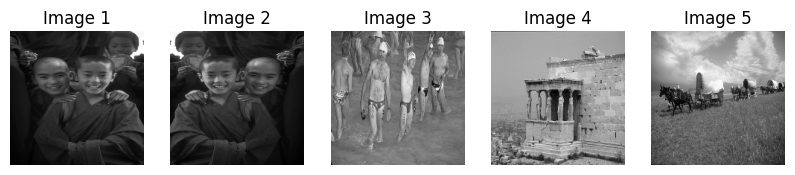

<Figure size 640x480 with 0 Axes>

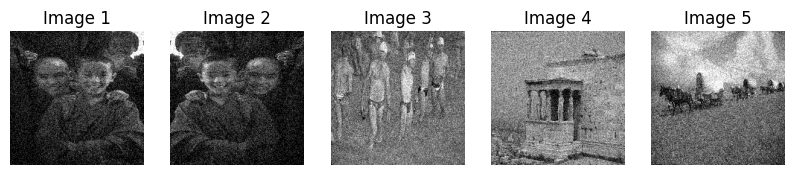

<Figure size 640x480 with 0 Axes>

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 2))
plt.figure()
for i in range(5):
    # print(np.shape(ytest[i,]))
    axes[i].imshow(original_images[i,], cmap='gray')
    axes[i].set_title(f'Image {i+1}')
    axes[i].axis('off')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 2))
plt.figure()
for i in range(5):
    # print(np.shape(ytest[i,]))
    axes[i].imshow(noisy_images[i,], cmap='gray')
    axes[i].set_title(f'Image {i+1}')
    axes[i].axis('off')
plt.show()

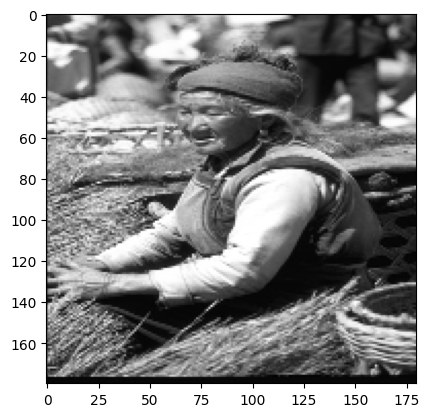

In [ ]:
plt.imshow(img, cmap='gray')


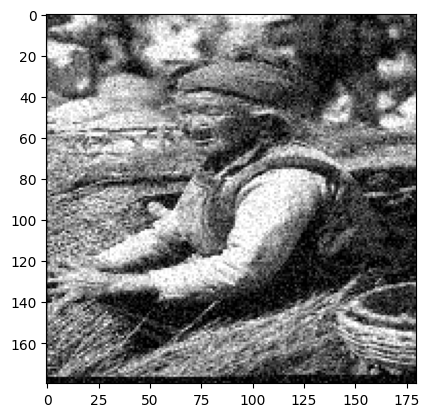

In [ ]:
plt.imshow(noisy_img, cmap='gray')

Now let's run the above code in a function, so we can apply it to the training, testing and validation datatsets. Then, let's save all the datasets as numpy arrays to load later. 

In [20]:
def preprocessDataDirectory(inputDir, 
    saveString, 
    convertToGrey = True,
    img_size = (180, 180),
    noise_var = 25):

    original_images = []
    noisy_images = []

    # Iterate over all images in the input directory
    for img_name in os.listdir(inputDir):
        # Load the input image
        img_path = os.path.join(inputDir, img_name)  
        if img_path[-3:] != "jpg":
                continue
        img = cv2.imread(img_path)

        # Convert to grayscale 
        if convertToGrey == True:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Scale the image to 0-255 range and crop to desired size
        img = (img - img.min()) / (img.max() - img.min()) * 255
        img = img.astype(np.uint8)
        img = cv2.resize(img, img_size)
        

        # Randomly flip or rotate the image
        rand_num = np.random.randint(0, 6)
        if rand_num == 0:
            img1 = cv2.flip(img, 0)
            imgnoisy1 = addNoise(img1, var=noise_var)
            imgnoisy = addNoise(img, var=noise_var)
            original_images.append(img)
            original_images.append(img1)
            noisy_images.append(imgnoisy)
            noisy_images.append(imgnoisy1)
        elif rand_num == 1:
            img1 = cv2.flip(img, 1)
            imgnoisy1 = addNoise(img1, var=noise_var)
            imgnoisy = addNoise(img, var=noise_var)
            original_images.append(img)
            original_images.append(img1)
            noisy_images.append(imgnoisy)
            noisy_images.append(imgnoisy1)
        elif rand_num == 2:
            img1 = np.rot90(img)
            imgnoisy1 = addNoise(img1, var=noise_var)
            imgnoisy = addNoise(img, var=noise_var)
            original_images.append(img)
            original_images.append(img1)
            noisy_images.append(imgnoisy)
            noisy_images.append(imgnoisy1)
        else: 
        # Add noise to the image
            original_images.append(img)
            imgnoisy1 = addNoise(img, var=noise_var)
            noisy_images.append(imgnoisy1)

    original_images = np.array(original_images, dtype=np.float32)
    noisy_images = np.array(noisy_images, dtype=np.float32)

    with open(saveString+'_original_array.npy', 'wb') as f:
      np.save(f,original_images)
    with open(saveString+'_noisy_array.npy', 'wb') as f:
      np.save(f,noisy_images)



In [21]:
preprocessDataDirectory(inputDir=test_dir, 
    saveString='./BSDS500/test')

preprocessDataDirectory(inputDir=train_dir, 
    saveString='./BSDS500/train')

preprocessDataDirectory(inputDir=val_dir, 
    saveString='./BSDS500/val')